<a href="https://colab.research.google.com/github/Jemal893/Jemal-Mohammed/blob/main/Module_1a_Seasonal_Aggregation_WaPOR_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 1a: Seasonal aggregation of WaPOR data

[![](https://raw.githubusercontent.com//wateraccounting/WaPORMOOC/main/images/colab-badge.png)](https://colab.research.google.com/github/wateraccounting/WaPORIPA/blob/main/Notebooks_beta/Module_1a_Seasonal_Aggregation_WaPOR_data.ipynb?target=\"_blank\")

In this Notebook we use a script that was developed for the WaPOR project to calculate temporal aggregation of WaPOR data (AETI, T and NPP), which are needed to run the irrigation performance assessment module.

We will be following these steps:

0. Import Python Libraries
1. Import WaPOR data
2. Define function for temporal aggregation
3. Calculate seasonal AETI, T and NPP
4. Calculate TBP from NPP

**Data used:**

For running this Notebook we used the following data which we downloaded using the [Download_WaPORv3_Data Notebook](https://github.com/wateraccounting/WaPORMOOC/blob/main/1_WaPOR_download_colab/Download_WaPORv3_Data.ipynb).

1. **Area**: Wad Helal in the Gezira Irrigation Scheme (you can find the \"Wad_Helal.geojson\" file in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC/tree/main/data))
2. **Type of Data**: AETI, T and NPP
3. **Spatial resolution**: Level 3
4. **Temporal resolution**: dekadal
5. **Start date**: 2022-10-01
6. **End date**: 2023-04-30

The function `SumSeason` used in this Notebook is based on [WaPORWP](https://github.com/wateraccounting/WAPORWP)
© 2020 Abebe Chukalla. Licensed under CC BY 4.0 Creative Commons.

 © 2024 IHE Delft Licenced under CC BY SA Creative Commons


---

## Step 0. Import modules/libraries

In [1]:
!pip install rioxarray --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 24.7 MB/s eta 0:00:00


In [2]:
import os                                 # a module for interacting with the operating system
import sys
import glob                               # used to retrieve files/pathnames matching a specified pattern
import re                                 # re sub() module can be used to replace substring
import rioxarray as rio
import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import calendar
import datetime
from matplotlib import pyplot as plt      # is a plotting library used for 2D graphics in python
from osgeo import gdal

Upload the data downloaded using [Download_WaPORv3_Data Notebook](https://github.com/wateraccounting/WaPORMOOC/blob/main/1_WaPOR_download_colab/Download_WaPORv3_Data.ipynb) to the temporary folder or mount the Colab Notebook and update file paths to the destination folder.

In [15]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [16]:
!unzip '/content/data.zip' -d '/content'

Archive:  /content/data.zip
   creating: /content/content/output/L2-NPP-D/
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2023-02-21.tif  
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2022-06-11.tif  
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2023-06-01.tif  
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2022-07-21.tif  
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2023-03-21.tif  
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2023-01-01.tif  
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2023-08-01.tif  
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2022-09-21.tif  
  inflating: /content/content/output/L2-NPP-D/KARC1_L2-NPP-D_NONE_dekad_converted_2023-02-11.tif  
  inflating: /content/content/outp

## Step 1. Import raster (WaPOR) data

In this section you will be importing the WaPOR data. First identify the location of the WaPORv3 data.

In [17]:
dir_proj = os.path.split(os.getcwd())[0]
dir_data = "/content/content/output/"
input_folderAETI = os.path.join(dir_proj, dir_data, "L2-AETI-D")
input_fhsAETI = glob.glob(os.path.join(input_folderAETI, '*.tif'))

input_folderT = os.path.join(dir_proj, dir_data, "L2-T-D")
input_fhsT = glob.glob(os.path.join(input_folderT, '*.tif'))

input_folderNPP = os.path.join(dir_proj, dir_data, "L2-NPP-D")
input_fhsNPP = glob.glob(os.path.join(input_folderNPP, '*.tif'))

<div class="alert alert-warning">

**NOTE:** Before continuing with the next steps, make sure that you already have the data needed in the folders below.

</div>

In [18]:
print('Folder of input AETI data: '+input_folderAETI)
print('Folder of input T data: '+input_folderT)
print('Folder of input NPP data: '+input_folderNPP)

Folder of input AETI data: /content/content/output/L2-AETI-D
Folder of input T data: /content/content/output/L2-T-D
Folder of input NPP data: /content/content/output/L2-NPP-D


This script defines (and create) the output folder (same folder for all seasonal files).

In [19]:
output_folderAETI = "/content/output/AETI_season"
output_folderT = "/content/output/T_season"
output_folderNPP = "/content/output/NPP_season"

if not os.path.exists(output_folderAETI):
    os.makedirs(output_folderAETI)
output_folderAETI

if not os.path.exists(output_folderT):
    os.makedirs(output_folderT)
output_folderT

if not os.path.exists(output_folderNPP):
    os.makedirs(output_folderNPP)
output_folderNPP


'/content/output/NPP_season'

## Step 2. Define function for temporal aggregation

This script defines the function `SumSeason` which is used in the next sections. Using functions in such a way improves the readability and replicability of the scripts and avoids errors. For example we need this function to aggregate AETI and NPP data.

© 2020 Abebe Chukalla. Licensed under CC BY 4.0 Creative Commons.

In [20]:
# summation of raster between two dates
def SumSeason(input_fhs, sowing_date, harvesting_date):

    # add rasters that falls within sowing and harvesting date
    Sums = 0
    for i, in_fh in enumerate(input_fhs):
        # open raster file and get start and end date from attributes
        ds = rio.open_rasterio(in_fh)
        ds = ds.where(ds!=ds.attrs['_FillValue'])
        if i == 0:
          attrs = ds.attrs
        raster_startdate = datetime.datetime.strptime(ds.attrs['start_date'], '%Y-%m-%d' ).date()
        raster_enddate   = datetime.datetime.strptime(ds.attrs['end_date'], '%Y-%m-%d' ).date()

        # accumulate full or part of the dekadal value
        if (raster_startdate >= sowing_date) & (raster_enddate <= harvesting_date):
            Sum = ds
            Sums += Sum
#             print ("1",in_fh)

        elif (raster_startdate <sowing_date)&(raster_enddate >sowing_date)&(raster_enddate <harvesting_date):
            Sum = ds
            Sum = Sum*((raster_enddate-sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("2",in_fh)

        elif (raster_startdate >sowing_date)&(raster_startdate <harvesting_date)&(raster_enddate >harvesting_date):
            Sum = ds
            Sum = Sum*((harvesting_date- raster_startdate)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("3",in_fh)

        elif (sowing_date>=raster_startdate)&(harvesting_date<=raster_enddate):
            Sum = ds
            Sum = Sum*((harvesting_date- sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("4",in_fh)
    attrs.update({'start_date':datetime.datetime.strftime(SOS, '%Y-%m-%d'),
              'end_date': datetime.datetime.strftime(EOS, '%Y-%m-%d'),
              'units' : 'mm/season'})
    del attrs['number_of_days']
    del attrs['temporal_resolution']
    del attrs['units_conversion_factor']

    Sums.attrs  = attrs
    return Sums

## Step 3. Calculate seasonal AETI, T and NPP

### Define seasons

Here the start (SOS) and end (EOS) dates for each season are defined.

In [ ]:
#season_periods = {
 #   'season1': {'SOS': '2021-12-01', 'EOS': '2022-04-30'},
  #  'season2': {'SOS': '2022-12-01', 'EOS': '2023-04-30'},
   # 'season3': {'SOS': '2023-12-01', 'EOS': '2024-04-30'}
#}


In [26]:
season_periods = {
   'season1': {'SOS': '2021-12-01', 'EOS': '2022-04-30'}
}

## i) Calculate seasonal Actual Evapotranspiration and Interception (AETI)

In this script the start and end date of each season is read and then the function `SumSeason` is called. Seasonally aggregated data is then saved, and mean and standard deviation (SD) calculated for each season. Final part of the script is plotting all maps.

the mean, SD for  2021-12-01/2022-04-30 = 291.9 & 102.2


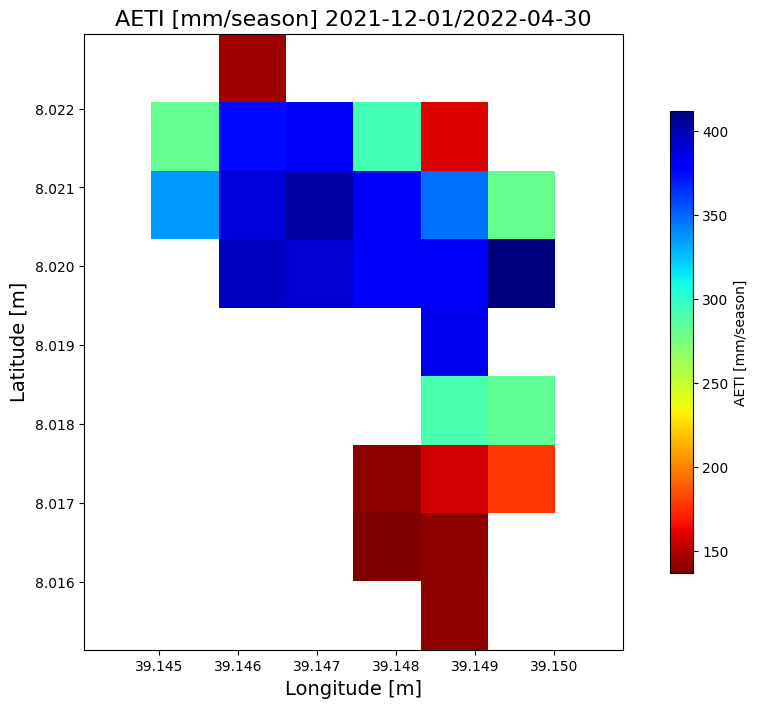

In [27]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsAETI
output_folder  = output_folderAETI


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'AETI' + '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='AETI [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('AETI [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

## ii) Calculate seasonal Transpiration (T)



the mean, SD for  2021-12-01/2022-04-30 = 202.9 & 105.7


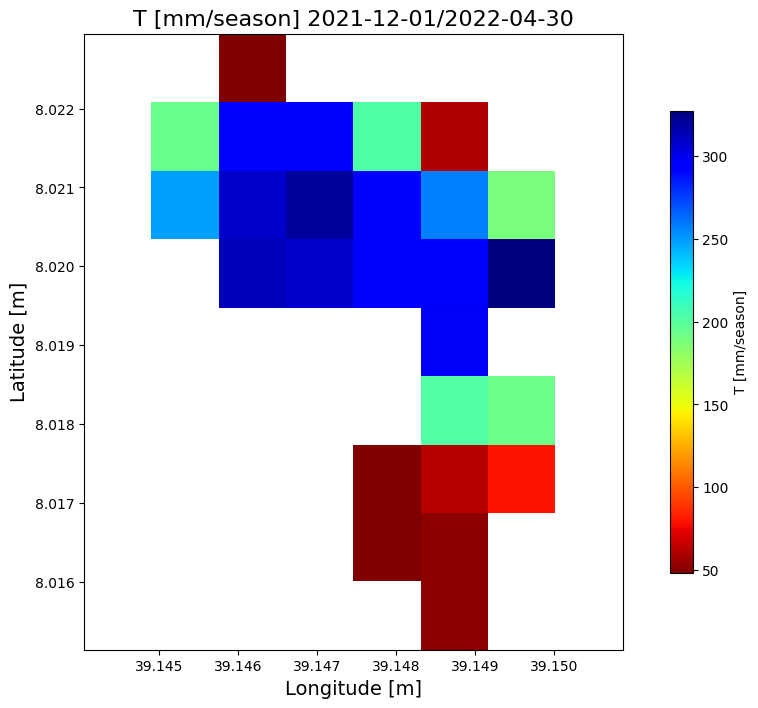

In [28]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsT
output_folder  = output_folderT


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'T' + '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='T [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('T [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

## iiI) Calculate seasonal Net Primary Production (NPP)

the mean, SD for  2021-12-01/2022-04-30 = 370.1 & 166.5


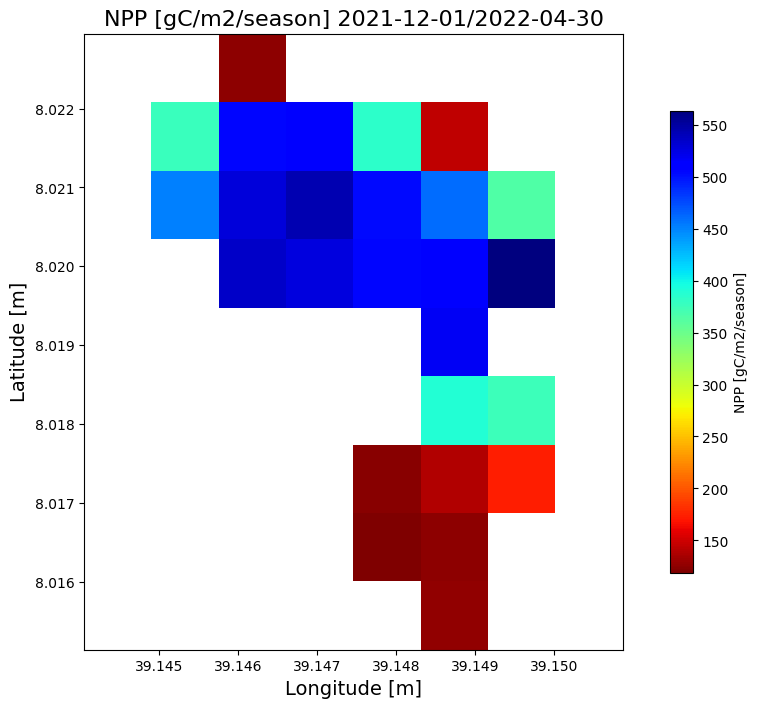

In [29]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsNPP
output_folder  = output_folderNPP


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'NPP' + '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='NPP [gC/m2/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('NPP [gC/m2/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();


## Zip and download seasonal data

In [30]:
!zip -r /content/WaPORv3_seasonal.zip /content/output/
from google.colab import files
files.download(r'/content/WaPORv3_seasonal.zip')


updating: content/output/ (stored 0%)
updating: content/output/T_season/ (stored 0%)
updating: content/output/T_season/T_season1_2022-10-01_to_2023-04-30.tif (deflated 87%)
updating: content/output/NPP_season/ (stored 0%)
updating: content/output/NPP_season/NPP_season1_2022-10-01_to_2023-04-30.tif (deflated 82%)
updating: content/output/AETI_season/ (stored 0%)
updating: content/output/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif (deflated 87%)
  adding: content/output/T_season/T_season1_2021-12-01_to_2024-04-30.tif (deflated 58%)
  adding: content/output/T_season/T_season1_2021-12-01_to_2022-04-30.tif (deflated 60%)
  adding: content/output/NPP_season/NPP_season1_2021-12-01_to_2024-04-30.tif (deflated 52%)
  adding: content/output/NPP_season/NPP_season1_2021-12-01_to_2022-04-30.tif (deflated 53%)
  adding: content/output/AETI_season/AETI_season1_2021-12-01_to_2022-04-30.tif (deflated 59%)
  adding: content/output/AETI_season/AETI_season1_2021-12-01_to_2024-04-30.tif (deflated

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>